# **Instrumental Variables**

**Notes:**

- Better suited for **unmeasured confounders** `U` that affect both the treament `A` and the outcome `Y `. Measurable confounders `X`.
    - ![u](./assets/u.png)
    ```mermaid
         flowchart TD;
            A --> Y;
            U --> A;
            U --> Y;
            X --> A;
            X --> Y;
    ```
- We could use an instrumental variable `Z`, which affects the treatment, but not directly affect the outcome. Also considered enouragement.
    - ![z](./assets/z.png)


In [1]:
#install needed libraries
install.packages("ivpack")

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘data.table’, ‘gower’, ‘ipred’, ‘lubridate’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘matrixStats’, ‘caret’, ‘RcppArmadillo’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘lme4’, ‘car’, ‘Formula’, ‘AER’, ‘lmtest’




## Load Libraries and Data

In [2]:
library(ivpack)

Loading required package: AER

Loading required package: car

Loading required package: carData

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival



In [43]:
data("lalonde")
lalonde$race_black = ifelse(lalonde$race=='black', 1, 0)
lalonde$race_hisp = ifelse(lalonde$race=='hispan', 1, 0)
head(lalonde)

,treat,age,educ,race,married,nodegree,re74,re75,re78,race_black,race_hisp
,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NSW1,1,37,11,black,1,1,0,0,9930.0460,1,0
NSW2,1,22,9,hispan,0,1,0,0,3595.8940,0,1
NSW3,1,30,12,black,0,0,0,0,24909.4500,1,0
NSW4,1,27,11,black,0,1,0,0,7506.1460,1,0
NSW5,1,33,8,black,0,1,0,0,289.7899,1,0
NSW6,1,22,9,black,0,1,0,0,4056.4940,1,0


In [44]:
#using table one
#covariates we will use (shorter list than you would use in practice)
covariates <-c ("age","educ", "race_black", "race_hisp", "married","nodegree","re74","re75")
covar_table_1 <- CreateTableOne(vars=covariates,strata="treat", data=lalonde, test=FALSE)
# include standardized mean difference (SMD)
print(covar_table_1,smd=TRUE)

                        Stratified by treat
                         0                 1                 SMD   
  n                          429               185                 
  age (mean (SD))          28.03 (10.79)     25.82 (7.16)     0.242
  educ (mean (SD))         10.24 (2.86)      10.35 (2.01)     0.045
  race_black (mean (SD))    0.20 (0.40)       0.84 (0.36)     1.668
  race_hisp (mean (SD))     0.14 (0.35)       0.06 (0.24)     0.277
  married (mean (SD))       0.51 (0.50)       0.19 (0.39)     0.719
  nodegree (mean (SD))      0.60 (0.49)       0.71 (0.46)     0.235
  re74 (mean (SD))       5619.24 (6788.75) 2095.57 (4886.62)  0.596
  re75 (mean (SD))       2466.48 (3292.00) 1532.06 (3219.25)  0.287


##  Propensity Score Matching

### Using GLM

In [45]:
model_ps <-glm("treat ~ age + educ + race_black+ race_hisp+ married + nodegree + re74 + re75",
    family=binomial(link ="logit"), data=lalonde)
summary(model_ps)


Call:
glm(formula = "treat ~ age + educ + race_black+ race_hisp+ married + nodegree + re74 + re75", 
    family = binomial(link = "logit"), data = lalonde)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7645  -0.4736  -0.2862   0.7508   2.7169  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.729e+00  1.017e+00  -4.649 3.33e-06 ***
age          1.578e-02  1.358e-02   1.162  0.24521    
educ         1.613e-01  6.513e-02   2.477  0.01325 *  
race_black   3.065e+00  2.865e-01  10.699  < 2e-16 ***
race_hisp    9.836e-01  4.257e-01   2.311  0.02084 *  
married     -8.321e-01  2.903e-01  -2.866  0.00415 ** 
nodegree     7.073e-01  3.377e-01   2.095  0.03620 *  
re74        -7.178e-05  2.875e-05  -2.497  0.01253 *  
re75         5.345e-05  4.635e-05   1.153  0.24884    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 751.49  on 613  deg

In [46]:
scores_ps <- predict(model_ps, type = "response")
summary(scores_ps)
#create weights
weights <- ifelse(lalonde$treat==1,1/(scores_ps),1/(1-scores_ps))
summary(weights)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00908 0.04854 0.12068 0.30130 0.63872 0.85315 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.009   1.052   1.170   1.905   1.623  40.077 

In [16]:
#apply weights to data
data_weighted <-svydesign(ids = ~ 1, data = lalonde, weights = ~ weights)

#weighted table 1
table_weighted <-svyCreateTableOne(vars = covariates, strata = "treat", 
                                 data = data_weighted, test = FALSE)
## Show table with SMD
print(table_weighted, smd = TRUE)

                        Stratified by treat
                         0                 1                 SMD   
  n                       616.00            553.63                 
  age (mean (SD))          27.10 (10.80)     25.57 (6.53)     0.172
  educ (mean (SD))         10.29 (2.74)      10.61 (2.05)     0.132
  race_black (mean (SD))    0.40 (0.49)       0.45 (0.50)     0.101
  race_hisp (mean (SD))     0.12 (0.32)       0.12 (0.33)     0.014
  married (mean (SD))       0.41 (0.49)       0.31 (0.47)     0.197
  nodegree (mean (SD))      0.62 (0.48)       0.57 (0.50)     0.112
  re74 (mean (SD))       4552.74 (6337.09) 2932.18 (5709.42)  0.269
  re75 (mean (SD))       2172.04 (3160.14) 1658.07 (3072.89)  0.165


### Using IPW

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.009   1.052   1.170   1.905   1.623  40.077 

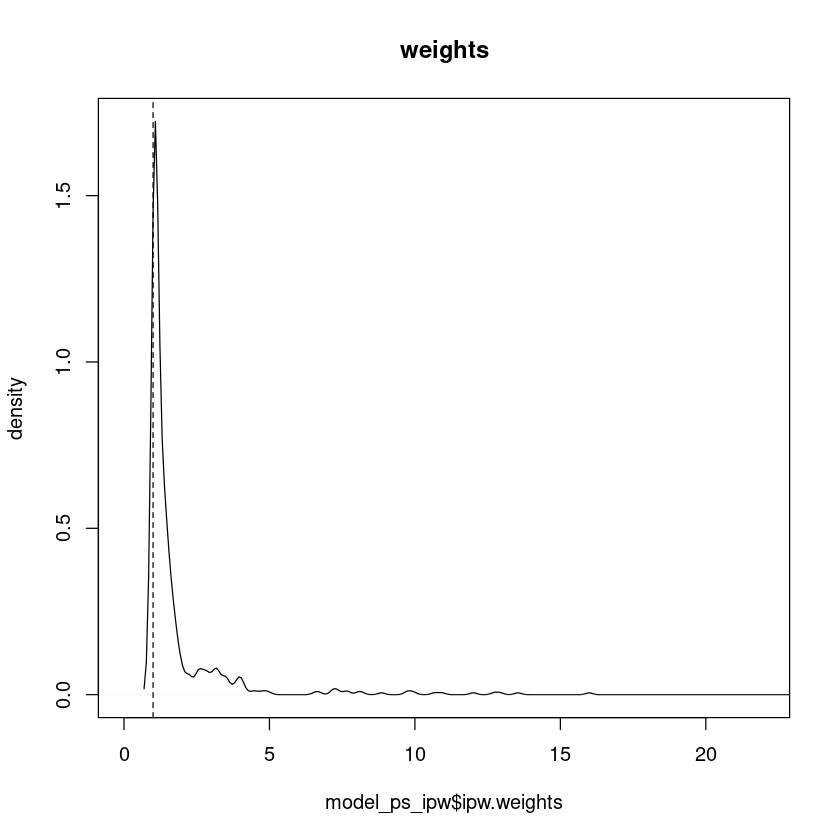

In [27]:
#first fit propensity score model to get weights
model_ps_ipw <-ipwpoint(exposure = treat, family = "binomial", link ="logit",
          denominator= ~ age + educ + race_black+ race_hisp+ married + nodegree + re74 + re75, data=lalonde)
#numeric summary of weights
summary(model_ps_ipw$ipw.weights)
#plot of weights
ipwplot(weights = model_ps_ipw$ipw.weights, logscale = FALSE,
         main = "weights", xlim = c(0, 22))

In [28]:
lalonde$wt<-model_ps_ipw$ipw.weights
#fit a marginal structural model (risk difference)
msm <- (svyglm(re78 ~ treat, design = svydesign(~ 1, weights = ~wt,
                  data =lalonde)))
coef(msm)
confint(msm, level = 0.95)

(Intercept)       treat 
  6422.8390    224.6763

,2.5 %,97.5 %
(Intercept),5705.529,7140.149
treat,-1562.856,2012.208


In [34]:
head(lalonde)

,treat,age,educ,race,married,nodegree,re74,re75,re78,race_black,race_hisp,wt
,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NSW1,1,37,11,black,1,1,0,0,9930.0460,1,0,1.565509
NSW2,1,22,9,hispan,0,1,0,0,3595.8940,0,1,4.451681
NSW3,1,30,12,black,0,0,0,0,24909.4500,1,0,1.474396
NSW4,1,27,11,black,0,1,0,0,7506.1460,1,0,1.288122
NSW5,1,33,8,black,0,1,0,0,289.7899,1,0,1.425235
NSW6,1,22,9,black,0,1,0,0,4056.4940,1,0,1.430472


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.012   1.052   1.170   1.818   1.623  12.631 

(Intercept)       treat 
  6422.9362    486.9336

,2.5 %,97.5 %
(Intercept),5705.614,7140.258
treat,-1093.765,2067.632


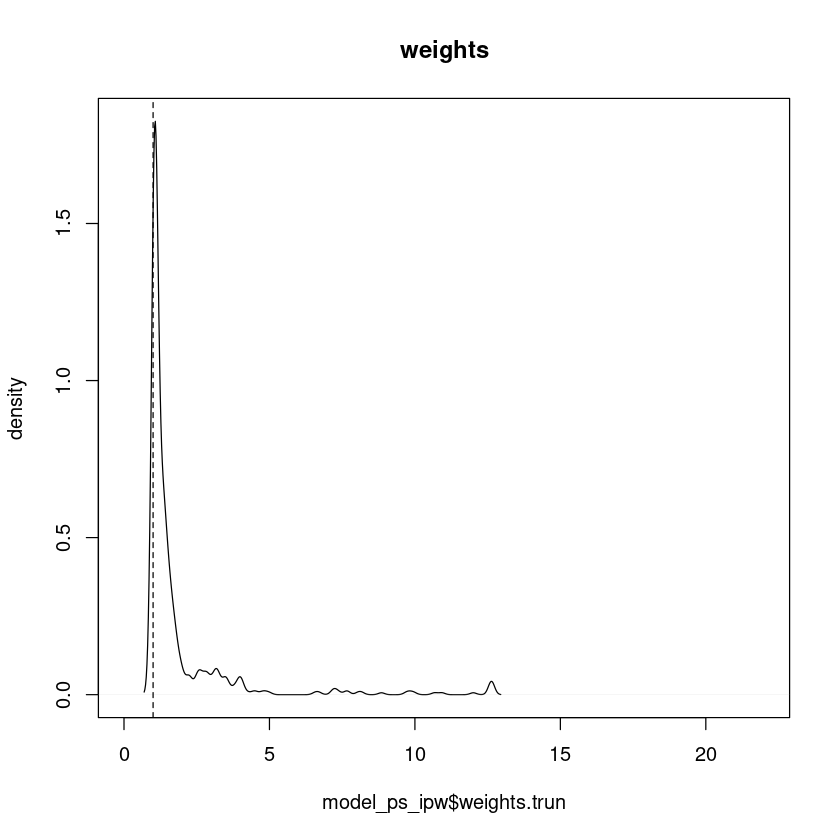

In [41]:
# Truncate
model_ps_ipw <-ipwpoint(exposure = treat, family = "binomial", link ="logit",
          denominator= ~ age + educ + race_black+ race_hisp+ married + nodegree + re74 + re75, data=lalonde, trunc=0.01)
#numeric summary of weights
summary(model_ps_ipw$weights.trun)
#plot of weights
ipwplot(weights = model_ps_ipw$weights.trun, logscale = FALSE,
         main = "weights", xlim = c(0, 22))


lalonde$wt<-model_ps_ipw$weights.trun
#fit a marginal structural model (risk difference)
msm <- (svyglm(re78 ~ treat, design = svydesign(~ 1, weights = ~wt,
                  data =lalonde)))
coef(msm)
confint(msm, level = 0.95)

In [28]:
y_trt <- greedy_match_ps_pairs$re78[greedy_match_ps_pairs$treat==1]
y_con <- greedy_match_ps_pairs$re78[greedy_match_ps_pairs$treat==0]
y_diff <- y_trt - y_con

#paired t-test
t.test(y_diff)


	One Sample t-test

data:  y_diff
t = 1.4824, df = 110, p-value = 0.1411
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -420.0273 2913.6398
sample estimates:
mean of x 
 1246.806 
